# 感情極性辞書を用いたツイートの感情解析(1)

## 実験手順
1. ツイート・テキストを形態素解析し，単語（表層形）を取り出す。ここで形態素解析に MeCab を用いる。
1. 極性辞書を参照し，各単語の極性 (p/n) を得る。positive な語を +1，negative な語を -1 としてカウントし，その合計をテキストの極性とみなす。ここで極性辞書として日本語評価極性辞書(名詞編)を用いる。

形態素解析エンジン MeCab
https://taku910.github.io/mecab/

日本語評価極性辞書（名詞編）
https://www.cl.ecei.tohoku.ac.jp/index.php?Open%20Resources%2FJapanese%20Sentiment%20Polarity%20Dictionary


## プログラムの解説

### MeCab を用いた形態素解析
MeCab においてタギング(tagging)を行うツールを tagger と呼ぶ。
tagger の生成は次の通り。"-Ochasen" は Chasen 形式の出力形式とする意味である。

    tagger = MeCab.Tagger("-Ochasen")

次に，形態素解析を行うメソッドが parseToNode() である。これにテキストを渡すことで，形態素のリストが得られる。形態素は表層形(surface)と素性(feature)から構成され，素性には品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音が含まれる。

また，parseToNode()の返す値は「形態素リスト」の先頭要素に対するポインタである。
故に，２番目以降の要素にアクセスする際，node = node.next によるポインタの書き換えが必要となる。

    while node:
        # node.surface が表層型，node.feature[6] が原形
        # node.feature の形式：品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音
        features = node.feature.split(',')
        if features[0] != "BOS/EOS":
            pos, genkei = features[0], features[6]
            print(node.surface, genkei, pos)
        node = node.next

なお，形態素リストの先頭／末尾はそれぞれ BOS (beggining of sentence; 文頭)，EOS (end of sentence；文末)という特殊な要素であり，素性の値は ["BOS/EOS"] として与えられる。

(注) POS とは "part of speech"，すなわち「品詞」の意味である。

In [41]:
tagger = MeCab.Tagger("-Ochasen")

text = "プログラミングを学んでスキルを身に付けよう"
tagger.parse('') # バグ回避のための措置
node = tagger.parseToNode(text)

while node:
    # node.surface : 表層型
    # node.feature の形式：品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音
    features = node.feature.split(',')
    if features[0] != "BOS/EOS":
        pos, genkei = features[0], features[6]
        print(node.surface, genkei, pos)
    node = node.next

プログラミング プログラミング 名詞
を を 助詞
学ん 学ぶ 動詞
で で 助詞
スキル スキル 名詞
を を 助詞
身 身 名詞
に に 助詞
付けよ 付ける 動詞
う う 助動詞


### 評価極性辞書
単語に対して positive / negative / neutral 等の極性を付与した辞書を「評価極性辞書」と呼ぶ。

本実験で用いる，東北大学 乾研究室の提供する日本語評価極性辞書は用言編と名詞編がある。

https://www.cl.ecei.tohoku.ac.jp/index.php?Open%20Resources%2FJapanese%20Sentiment%20Polarity%20Dictionary

今回は「名詞編」を用いることとする。

日本語評価極性辞書（名詞編）は以下のような構造となっており，今回は第１列の単語および第２列の p/n の極性ラベルのみを用いる。ここで p は positive，n は negative を表す。

    空腹	n	?である・になる（評価・感情）主観
    空腹感	n	?がある・高まる（存在・性質）
    ・・・・・
    軽快	p	?である・になる（評価・感情）主観
    軽軽	p	?である・になる（評価・感情）主観
    軽減	p	?する（行為）

下記のコードは評価極性辞書ファイル "n.csv.m3.120408.trim" より単語と極性ラベルを取り出し，Python 辞書に格納する処理である。

In [44]:
def read_pn_dic():
    pn_dic = dict()
    with open('pn.csv.m3.120408.trim', 'r', encoding='utf-8') as f:
        for line in f.readlines():
            data = line.rstrip('\n').split('\t')
            if data[1] == 'p' or data[1] == 'n':
                pn_dic[data[0]] = data[1]
            
    return pn_dic

pn_dic = read_pn_dic()
print(pn_dic)

{'１位': 'p', '１周年記念': 'p', '１勝': 'p', '１番': 'p', '２次感染': 'n', '２失点': 'n', '３連敗': 'n', 'ＡＩＤＳ': 'n', 'ＡＴフィールド': 'p', 'Ａ型肝炎': 'n', 'ＢＩＧ': 'p', 'ＢＯＴ': 'n', 'ＢＳＥ': 'n', 'Ｃ型肝炎': 'n', 'ＤＶ': 'n', 'ＥＤ': 'n', 'ＨＩＶ': 'n', 'ＨＩＶ感染': 'n', 'ＫＯ': 'p', 'ＮＧ': 'n', 'ＰＭＳ': 'n', 'ＰＴＳＤ': 'n', 'ＳＡＲＳ': 'n', 'ＴＫＯ': 'n', 'あいまい': 'n', 'あからさま': 'n', 'あきらめ': 'n', 'あく抜け': 'p', 'あこがれ': 'p', 'あざやか': 'p', 'あせも': 'n', 'あたたかさ': 'p', 'あだ': 'n', 'あだおろそか': 'n', 'あだおろそか・あだやおろそか': 'n', 'あだやおろそか': 'n', 'あっぱれ': 'p', 'あでやか': 'p', 'あどけなさ': 'p', 'あなたらしさ': 'p', 'ありがたさ': 'p', 'ありがたみ': 'p', 'ありがた迷惑': 'n', 'いい気持ち': 'p', 'いい気持ち／気分': 'p', 'いい気分': 'p', 'いかがわしさ': 'n', 'いかさま': 'n', 'いさかい': 'n', 'いざこざ': 'n', 'いじめ': 'n', 'いじらしさ': 'p', 'いたずら': 'n', 'いたずら電話': 'n', 'いたみ': 'n', 'いたわり': 'p', 'いとしさ': 'p', 'いのち': 'p', 'いばらの道': 'n', 'いびき': 'n', 'いびり': 'n', 'いぼ': 'n', 'いやらしさ': 'n', 'いらいら': 'n', 'いらだち': 'n', 'うかうか': 'n', 'うかつ': 'n', 'うさ': 'n', 'うさんくささ': 'n', 'うずき': 'n', 'うそ': 'n', 'うそっぱち': 'n', 'うそ偽り': 'n', 'うそ八百': 'n', 'うたぐり': 'n', 'うだうだ': 'n', 'うっかり

### テキストの評価極性
テキスト中に含まれる単語の評価極性を得て，positive な語を +1，negative な語を -1 としてカウントし，その合計をテキストの極性とみなす。

以下はテキストの評価極性を求めるコードである。

当然，評価極性辞書に含まれない単語が出現した場合，KeyError が発生することから，try ～ except 文で処理している。

In [46]:
def get_emotion_score(pn_dic, words):
    emotion_score = 0
    for word in words:
        try:
            pn = pn_dic[word]
            if pn == 'p':
                emotion_score += 1
            elif pn == 'n':
                emotion_score -= 1
        except KeyError:
            pass
        
    return emotion_score

get_emotion_score(pn_dic,
                  ["空腹", "が", "さらに", "空腹", "を", "呼ぶ"])

-2

## コードの全体像
以上のコードをまとめた結果を以下に示す。

In [53]:
import MeCab
import sys
import datetime

# 日本語評価極性辞書（名詞編）を用いて極性判定する
# https://www.cl.ecei.tohoku.ac.jp/index.php?Open%20Resources%2FJapanese%20Sentiment%20Polarity%20Dictionary
# 辞書のファイル名：pn.csv.m3.120408.trim
# ラベルは p/n/e ・・・(メモ) e ってなんだ？

def read_pn_dic():
    pn_dic = dict()
    with open('pn.csv.m3.120408.trim', 'r', encoding='utf-8') as f:
        for line in f.readlines():
            data = line.rstrip('\n').split('\t')
            if data[1] == 'p' or data[1] == 'n':
                pn_dic[data[0]] = data[1]
             
    return pn_dic

def get_words(text):
    tagger = MeCab.Tagger("-Ochasen")
    tagger.parse('') # バグ回避のための措置
    node = tagger.parseToNode(text)
    
    words = []
    while node:
        # node.surface : 表層型
        # node.feature の形式：品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音
        #print(node.feature)

        features = node.feature.split(',')
        if features[0] != "BOS/EOS":
            pos, genkei = features[0], features[6]
            # print(node.surface, genkei, hinshi) # for DEBUG

            # 表層形を記録する
            words.append(node.surface)
        node = node.next

    return words

def get_emotion_score(pn_dic, words):
    emotion_score = 0
    for word in words:
        try:
            pn = pn_dic[word]
            if pn == 'p':
                emotion_score += 1
            elif pn == 'n':
                emotion_score -= 1
        except KeyError:
            pass
        
    return emotion_score

'''
ファイルの形式は
status_id \t retweet_count \t favorite_coun \t text
'''
if __name__ == '__main__':
    # 極性辞書の読み込み
    pn_dic = read_pn_dic()

    score_counter = dict()

    # 開始時刻をメモ
    start_time = datetime.datetime.now()

    with open("Tweets/20200401_MERS.txt", "r", encoding='utf-8') as f:
        for line in f.readlines():
            # 何故か分からないが，(id, retweet_count 等が含まれないテキストのみの行が存在する
            try:
                status_id, retweet_count, favorite_count, text = line.rstrip('\n').split('\t')
            except ValueError:
                pass
                # print(line)
                # sys.exit(1)
                
            status_id = int(status_id)
            retweet_count = int(retweet_count)
            favorite_count = int(favorite_count)

            # テキストの単語への分割　＆ 極性スコアの取得
            emotion_score = get_emotion_score(pn_dic, get_words(text))
            print("{}: {}".format(emotion_score, text)) # テキストとスコアの表示

            try:
                score_counter[emotion_score] += 1
            except:
                score_counter[emotion_score] = 1

    # 終了時刻をメモ
    end_time = datetime.datetime.now()

    print("=== emtion score frequency ===")
    print(sorted(score_counter.items()))
    
    print("処理時間 {}".format(end_time - start_time))

0: 「臨時便は今月６日、首都ビエンチャンから成田空港に向けて出発することになっていて定員は125人だということです。」&gt; 新型コロナウイルスの感染拡大の影響で、東南アジアのラオスで帰国できない状況になっていた現地の日本人のために臨時の… https://t.co/f8hx9L3gun
-1: @pe_pe_pe_pen @nhk_news 新型コロナウイルスだったみたいですね
-3: 【在バンクーバー日本総領事館からのお知らせ②】1/2  ●４月１日、日本政府は、新型コロナウイルス感染症の拡大に伴う水際対策強化に係る新たな措置として、カナダを含む４９か国・地域からの日本人を含む入国者に対し、PCR検査の実施、検疫所長の指定する場所での１４日間の待機、
-2: 気づけば、アメリカでのコロナウイルスによる死亡者は、同時多発テロでの死亡者を軽く超えてしまってる‥  さぁ、今日あなたは感染拡大させない為に何が出来ますか？ 何をして人の命を守りますか？  私は今日搭乗予定だった飛行機をキャンセルしました。  #感染予防のためにできること
-1: まじ、満員電車やだ、 隠れミッキーのように潜んでいるんだろうな、コロナウイルスの試薬さえあれば、
-3: ワイドショー見てる  コロナでTV業界も打撃とか言い出したからTBSに呆れた  読売TVは京大准教授でウイルス研究してるという例の先生のTwitter紹介してる この人はウイルスやってるけど動物のお医者さん  #グッとラック #スッキリ
-1: 新型コロナウイルス、人にうつさない配慮。自己管理。経済低迷し始めて、本性、人格が明確に出てる。 #コロナウィルス
1: マレーシアの新型コロナウイルスの流行状況についての最新情報を更新しました  https://t.co/duWhez1CPH
4: #ポケ森 #どうぶつの森 キキくんはコロナウイルスと無縁の安全な場所で、現世界の元気づけと希望のために、一生懸命バイトしています(๑⃙⃘♥‿♥๑⃙⃘) https://t.co/QMtJnp9FzY
-6: 【ドヤフェス石巻延期のお知らせ】  新型コロナウイルスの感染が驚異的に拡大する現在、移動に伴う出演者の感染リスク、参加者、関係者の感染リスクを鑑みて、「ドヤフェス石巻」の開催を延期させていただきます。  皆さんと笑ってお会いできる日

### (参考) 感情極極性スコアの分布
テキストの感情極性はマイナスからプラスの範囲で様々な値をとる。
もちろん，極性なし（極性ゼロ）付近が高頻度と考えられる。

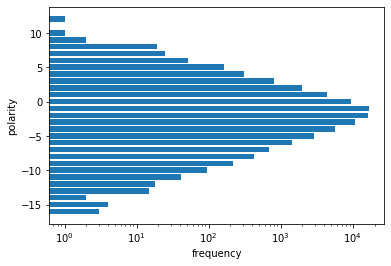

In [52]:
import matplotlib.pyplot as plt
x = []
y = []
for k, v in score_counter.items():
    x.append(k)
    y.append(v)
plt.barh(x, y, log=True)
plt.xlabel("frequency")
plt.ylabel("polarity")
plt.show()